In [2]:
import sys
import os
import subprocess

from six import string_types

# Make sure you have all of these packages installed, e.g. via pip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display

%matplotlib inline

from sklearn.metrics import fbeta_score
import cv2

sns.set(context="notebook", palette="coolwarm", style = 'ticks', font_scale = 1.2, color_codes=True)

In [3]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.6 MB/s 


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow_addons.metrics import FBetaScore
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import itertools
import shutil
import os
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
labels_df = pd.read_csv('/content/drive/MyDrive/Hamoye/train_v2.csv')
print(labels_df.shape)
labels_df.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
# Build list with unique labels
label_list = []
labels_count = dict()
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        label_list.append(label)
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 1
labels_count = dict(sorted(labels_count.items(), key=lambda val: val[1], reverse=True))

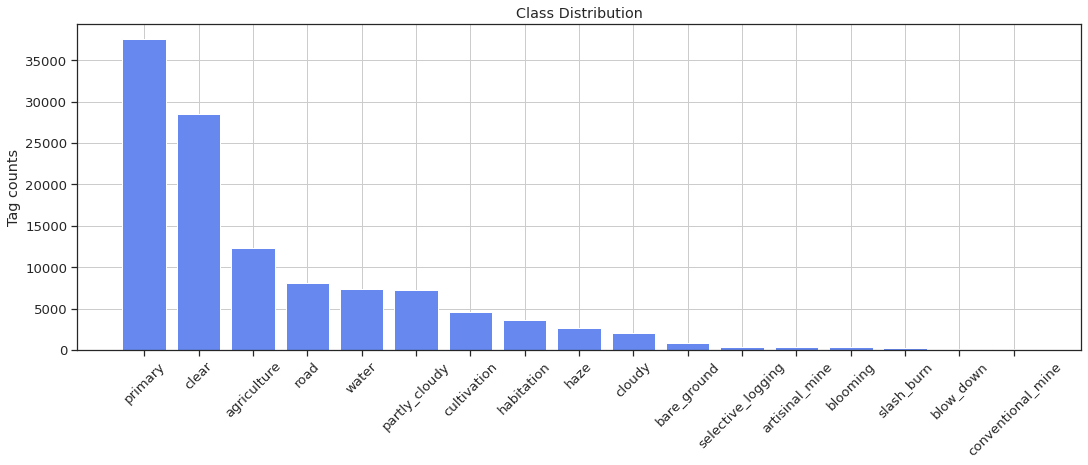

In [ ]:
#plot the distribution of the labels
plt.figure(figsize=(18, 6))
plt.title('Class Distribution')
idx = range(len(labels_count.values()))
plt.bar(x=labels_count.keys(), height=labels_count.values())
plt.ylabel('Tag counts')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [7]:
df = labels_df.copy()

In [8]:
# prepare the data suitable for multi-label classification using flow_from_dataframe
df['image_name'] = df['image_name'].apply(lambda x: f"{x}.jpg")
df['tags'] = df['tags'].apply(lambda x: x.split(' '))
df.head()

,image_name,tags
0,train_0.jpg,"[haze, primary]"
1,train_1.jpg,"[agriculture, clear, primary, water]"
2,train_2.jpg,"[clear, primary]"
3,train_3.jpg,"[clear, primary]"
4,train_4.jpg,"[agriculture, clear, habitation, primary, road]"


In [9]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if print('Number of GPUs Available', len(physical_devices)):
    tf.config.experimental.set_memory_growth(device=physical_devices[0], enable=True)

Number of GPUs Available 1


In [10]:
#shuffle the data
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,image_name,tags
0,train_33087.jpg,"[agriculture, clear, habitation, primary, road]"
1,train_305.jpg,"[partly_cloudy, primary]"
2,train_19454.jpg,"[agriculture, clear, primary, road]"
3,train_27499.jpg,"[agriculture, clear, cultivation, habitation, ..."
4,train_8195.jpg,"[clear, habitation, primary]"


In [11]:
unique_labels = list(set(label_list))
train_path = '/content/planet/planet/train-jpg'
train_generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(dataframe=df[:32384], directory=train_path,
                                                                          x_col='image_name', y_col='tags',
                                                                          batch_size=32, seed=42, shuffle=True,
                                                                          class_mode='categorical',
                                                                          classes=unique_labels,
                                                                          target_size=(224,224)
                                                                          )

valid_generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(dataframe=df[32384:], directory=train_path,
                                                                          x_col='image_name', y_col='tags',
                                                                          batch_size=32, seed=42, shuffle=True,
                                                                          class_mode='categorical',
                                                                          classes=unique_labels,
                                                                          target_size=(224,224))

Found 32384 validated image filenames belonging to 17 classes.
Found 8095 validated image filenames belonging to 17 classes.


In [15]:
# test data
sample_submission = pd.read_csv('/content/planet/planet/sample_submission.csv')
#add file extension .jpg to all the file names
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: f"{x}.jpg")
test_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
additional_test_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)

In [84]:
# Test generator
test_path = '/content/planet/planet/test-jpg'
additional_test_path = '/content/test-jpg-additional/test-jpg-additional'
test_generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(dataframe=test_df,
                                                                         directory=test_path,
                                                                         x_col='image_name',
                                                                         batch_size=32,
                                                                         seed=42, shuffle=False,
                                                                         class_mode=None, target_size=(224,224))

additional_test_generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(dataframe=additional_test_df,
                                                                                    directory=additional_test_path,
                                                                                    x_col='image_name',
                                                                                    batch_size=32,
                                                                                    seed=42, shuffle=False,
                                                                                    class_mode=None,
                                                                                    target_size=(224,224))

test_step_size = int(np.ceil(test_generator.n/test_generator.batch_size))
additional_test_step_size = int(np.ceil(additional_test_generator.n/additional_test_generator.batch_size))

Found 40669 validated image filenames.
Found 20522 validated image filenames.


In [81]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.5),

    Flatten(),

    Dense(1024, activation='relu'),
    Dense(17, activation='sigmoid') 
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[FBetaScore(num_classes=17, beta=2.0)])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 111, 111, 64)      18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 64)      36928     
                                                      

In [83]:
train_step_size = int(np.ceil(train_generator.n/train_generator.batch_size))
valid_step_size = int(np.ceil(valid_generator.n//valid_generator.batch_size))
history = model.fit(x=train_generator, steps_per_epoch=train_step_size,
                    validation_data=valid_generator, validation_steps=valid_step_size,
                    epochs=20)

Epoch 1/20
1012/1012 [==============================] - 214s 211ms/step - loss: 0.1873 - fbeta_score: 0.0947 - val_loss: 0.2282 - val_fbeta_score: 0.1036
Epoch 2/20
1012/1012 [==============================] - 195s 192ms/step - loss: 0.1746 - fbeta_score: 0.1019 - val_loss: 0.4499 - val_fbeta_score: 0.0858
Epoch 3/20
1012/1012 [==============================] - 196s 194ms/step - loss: 0.1650 - fbeta_score: 0.1089 - val_loss: 0.2320 - val_fbeta_score: 0.0980
Epoch 4/20
1012/1012 [==============================] - 195s 193ms/step - loss: 0.1596 - fbeta_score: 0.1113 - val_loss: 0.1610 - val_fbeta_score: 0.1135
Epoch 5/20
1012/1012 [==============================] - 196s 194ms/step - loss: 0.1559 - fbeta_score: 0.1145 - val_loss: 0.2076 - val_fbeta_score: 0.0672
Epoch 6/20
1012/1012 [==============================] - 195s 193ms/step - loss: 0.1515 - fbeta_score: 0.1151 - val_loss: 0.1507 - val_fbeta_score: 0.1242
Epoch 7/20
1012/1012 [==============================] - 195s 193ms/step - lo

In [85]:
# predict
test_generator.reset()
test_pred = model.predict(x=test_generator, batch_size=32, steps=test_step_size, verbose=1)

test_pred_bool = (test_pred>0.5)
test_predictions = []
labels = train_generator.class_indices #get the labels and thier coresponding indices
labels = dict((v,k) for k, v in labels.items()) # reverse the index and label for each
#get the actual predictions
for row in test_pred_bool:
  tag = []
  for index, cls in enumerate(row):
    if cls:
      tag.append(labels[index]) # this is the reason why index and labels were reversed above
  test_predictions.append(' '.join(tag))

test_image_names = test_generator.filenames
test_result = pd.DataFrame({'image_name': test_image_names, 'tags': test_predictions})


1271/1271 [==============================] - 127s 100ms/step


In [86]:
#predicting for the additional test images
additional_test_generator.reset()
additional_test_pred = model.predict(x=additional_test_generator, batch_size=32, steps=additional_test_step_size, verbose=1)

642/642 [==============================] - 67s 104ms/step


In [87]:
additional_test_pred_bool = (additional_test_pred>0.5)
additional_test_predictions = []
labels = train_generator.class_indices #get the labels and thier coresponding indices
labels = dict((v,k) for k, v in labels.items()) # reverse the index and label for each
#get the actual predictions
for row in additional_test_pred_bool:
    tag = []
    for index, cls in enumerate(row):
        if cls:
            tag.append(labels[index]) # this is the reason why index and labels were reversed above
    additional_test_predictions.append(' '.join(tag))

additional_test_image_names = additional_test_generator.filenames
additional_test_result = pd.DataFrame({'image_name': additional_test_image_names, 'tags': additional_test_predictions})
additional_test_result.head()

,image_name,tags
0,file_0.jpg,clear primary
1,file_1.jpg,agriculture partly_cloudy primary
2,file_10.jpg,haze primary water
3,file_100.jpg,clear primary
4,file_1000.jpg,clear primary


In [88]:
# Concatenating the two dataframes
final_result = pd.concat([test_result, additional_test_result]).reset_index().drop('index', axis=1)
# remove the .jpg extension
final_result['image_name'] = final_result['image_name'].apply(lambda x: x.split('.')[0])

#save the result to a csv file using the .to_csv() 
final_result.to_csv('/content/drive/MyDrive/Hamoye/submission2.csv', index = False)

In [89]:
final_result.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear primary
4,test_4,cloudy


## model2

In [12]:
model2 = Sequential()
model2.add(BatchNormalization(input_shape=(224, 224, 3)))
model2.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(17, activation='sigmoid'))

opt = Adam(lr=1e-4)
    
# We need binary here, since categorical_crossentropy l1 norms the output before calculating loss.
model2.compile(loss='binary_crossentropy',
          optimizer=Adam(learning_rate=0.001),
          metrics=[FBetaScore(num_classes=17, beta=2.0)])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 111, 111, 64)      1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
#fitting model2
train_step_size = int(np.ceil(train_generator.n/train_generator.batch_size))
valid_step_size = int(np.ceil(valid_generator.n/valid_generator.batch_size))

In [14]:
history2 = model2.fit(x=train_generator, steps_per_epoch=train_step_size,
                    validation_data=valid_generator, validation_steps=valid_step_size,
                    epochs=20)

Epoch 1/20
1012/1012 [==============================] - 189s 172ms/step - loss: 0.2116 - fbeta_score: 0.0778 - val_loss: 0.1710 - val_fbeta_score: 0.0758
Epoch 2/20
1012/1012 [==============================] - 173s 171ms/step - loss: 0.1680 - fbeta_score: 0.0991 - val_loss: 0.1642 - val_fbeta_score: 0.0918
Epoch 3/20
1012/1012 [==============================] - 174s 172ms/step - loss: 0.1556 - fbeta_score: 0.1063 - val_loss: 0.1463 - val_fbeta_score: 0.1063
Epoch 4/20
1012/1012 [==============================] - 174s 171ms/step - loss: 0.1496 - fbeta_score: 0.1095 - val_loss: 0.1395 - val_fbeta_score: 0.1021
Epoch 5/20
1012/1012 [==============================] - 174s 172ms/step - loss: 0.1418 - fbeta_score: 0.1119 - val_loss: 0.1402 - val_fbeta_score: 0.0872
Epoch 6/20
1012/1012 [==============================] - 174s 171ms/step - loss: 0.1356 - fbeta_score: 0.1137 - val_loss: 0.1346 - val_fbeta_score: 0.0959
Epoch 7/20
1012/1012 [==============================] - 174s 172ms/step - lo

In [22]:
# Save the model weights
model2.save_weights('/content/drive/MyDrive/Hamoye/amazon_from_space_weights.h5')

In [63]:
test_generator.reset()
test_pred = model2.predict(x=test_generator, batch_size=32, steps=test_step_size, verbose=1)

1271/1271 [==============================] - 121s 95ms/step


In [ ]:
test_pred_bool = (test_pred>0.5)
test_predictions = []
labels = train_generator.class_indices #get the labels and thier coresponding indices
labels = dict((v,k) for k, v in labels.items()) # reverse the index and label for each
#get the actual predictions
for row in test_pred_bool:
    tag = []
    for index, cls in enumerate(row):
        if cls:
            tag.append(labels[index]) # this is the reason why index and labels were reversed above
    test_predictions.append(' '.join(tag))

test_image_names = test_generator.filenames
test_result = pd.DataFrame({'image_name': test_image_names, 'tags': test_predictions})


In [69]:
#predicting for the additional test images
additional_test_generator.reset()
additional_test_pred = model2.predict(x=additional_test_generator, batch_size=32, steps=additional_test_step_size, verbose=1)

642/642 [==============================] - 62s 96ms/step


In [ ]:
additional_test_pred_bool = (additional_test_pred>0.5)
additional_test_predictions = []
labels = train_generator.class_indices #get the labels and thier coresponding indices
labels = dict((v,k) for k, v in labels.items()) # reverse the index and label for each
#get the actual predictions
for row in additional_test_pred_bool:
    tag = []
    for index, cls in enumerate(row):
        if cls:
            tag.append(labels[index]) # this is the reason why index and labels were reversed above
    additional_test_predictions.append(' '.join(tag))

additional_test_image_names = additional_test_generator.filenames
additional_test_result = pd.DataFrame({'image_name': additional_test_image_names, 'tags': additional_test_predictions})
additional_test_result.head()

### Concatenate the two prediction dataframes

In [79]:
final_result = pd.concat([test_result, additional_test_result]).reset_index().drop('index', axis=1)
# remove the .jpg extension
final_result['image_name'] = final_result['image_name'].apply(lambda x: x.split('.')[0])

#save the result to a csv file using the .to_csv() 
final_result.to_csv('/content/drive/MyDrive/Hamoye/submission.csv', index = False)

In [80]:
final_result.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear primary
4,test_4,partly_cloudy primary


Reference: https://github.com/prof2022/Stage_D_Amozon_Competition/blob/Master/Stage_D_Quiz_Amazon_Competition.ipynb